In [ ]:
# Author: Sachuriga
# Email: sachuriga3@gmail.com
# Purpose: Process CSV files and add their columns to corresponding NWB files

import pandas as pd
from pynwb import NWBHDF5IO
import os

target_prefixes_control= ['65165', '65091', '63383', '66539','65622','283']
target_prefixes_exp = ['65588', '63385', '66538', '66537','66922']


# Set your base folder path
base_folder = 'S:/Sachuriga/nwb/test4neo'

# Get all files in the directory
all_files = os.listdir(base_folder)

# Filter for CSV and NWB files and create pairs
csv_files = [f for f in all_files if f.endswith('.csv')]
nwb_files = [f for f in all_files if f.endswith('.nwb')]

# Process each pair of files
for csv_file in csv_files:
    # Try to find a matching NWB file (assuming similar base names)
    base_name = os.path.splitext(csv_file)[0]
    nwb_file = f"{base_name}.nwb"
    
    if nwb_file in nwb_files:
        csvpath = os.path.join(base_folder, csv_file)
        nwbpath = os.path.join(base_folder, nwb_file)
        
        try:
            # Read the CSV file
            df = pd.read_csv(csvpath)
            
            # Get column names
            column_names = df.columns.tolist()
            
            # Open and modify NWB file
            with NWBHDF5IO(nwbpath, "a") as io:
                nwb = io.read()
                for col in column_names:
                    print(f"Processing column: {col}")
                    nwb.units.add_column(
                        name=f"matlab_{col}",
                        description=f"values of {col}",
                        data=df[col].tolist()
                    )
        
                # Uncomment these if you need to modify subject info
                # nwb.subject.genotype = "NDNF-flp +/- and Pde1c +/-"
                # nwb.subject.set_modified()


                # nwb.subject.genotype = "NDNF-flp-/- and Pde1c -/-"
                
                io.write(nwb)
            print(f"Successfully processed {csv_file} into {nwb_file}")
            
        except Exception as e:
            print(f"Error processing {csv_file}: {str(e)}")
    else:
        print(f"Warning: No matching NWB file found for {csv_file}")

print("Processing complete!")

Processing column: animal
Processing column: day
Processing column: session
Processing column: UIfile
Processing column: UIanimal_session
Processing column: acg_tau_rise
Processing column: UIfile_1
Processing column: UIanimal_session_1
Processing column: acg_tau_rise_1
Processing column: speedScores
Processing column: stability_smooth1
Processing column: test_stat_si
Processing column: boarderscore
Processing column: fields
Processing column: sparsity
Processing column: maxfsize
Processing column: reject_h0
Processing column: id
Successfully processed 63383_2024-07-10_15-37-51_A_phy_k_manual.csv into 63383_2024-07-10_15-37-51_A_phy_k_manual.nwb
Processing column: animal
Processing column: day
Processing column: session
Processing column: UIfile
Processing column: UIanimal_session
Processing column: acg_tau_rise
Processing column: UIfile_1
Processing column: UIanimal_session_1
Processing column: acg_tau_rise_1
Processing column: speedScores
Processing column: stability_smooth1
Processin

KeyboardInterrupt: 

In [ ]:
import pandas as pd
from pynwb import NWBHDF5IO
import os
from pathlib import Path
from pynwb.file import Subject

# Output path for the summary table
output_path = r'Q:/sachuriga/Temporal/CR_CA1_paper/tables/'

# Set your base folder path
base_folder = 'S:/Sachuriga/nwb/test4neo/'

# Define animal groups
target_prefixes_control = ['65165', '65091', '63383', '66539', '65622']
target_prefixes_exp = ['65588', '63385', '66538', '66537', '66922']
males = ['65165', '63383', '66539', '63385', '65622']
females = ['65091', '65588', '66538', '66537', '66922']
surgry_sachuriga = ['65165', '63383', '66539', '63385', '65091', '65588', '66538', '66537', '65283']
surgry_ingvild = ['66922', '65622']

# Initialize a dictionary to store summary data for each animal
summary_data = {}

# Get all NWB files in the directory
all_files = os.listdir(base_folder)
nwb_files = [f for f in all_files if f.endswith('.nwb')]
print(f"Found {len(nwb_files)} NWB files: {nwb_files}")

# Process each NWB file
for nwb_file in nwb_files:
    nwbpath = os.path.join(base_folder, nwb_file)
    print(f"Processing {nwbpath}")

    # Open and modify NWB file for metadata
    with NWBHDF5IO(Path(nwbpath), "a") as io:
        nwb = io.read()
        animal_id = nwbpath.split('/')[-1][:5]
        print(f"Animal ID: {animal_id}")

        # Assign sex
        sex = "M" if animal_id in males else "F" if animal_id in females else "Unknown"

        # Initialize genotype and experimenter as None in case they aren't set
        genotype = None
        experimenter = None

        # Create or update subject
        try:
            subject = Subject(
                subject_id=animal_id,
                age="P90D",
                description="mouse 5",
                species="Mus musculus",
                sex=sex)
            nwb.subject = subject
            
            if animal_id in target_prefixes_control:
                nwb.subject.genotype = "NDNF-flp-/- and Pde1c -/-"
            elif animal_id in target_prefixes_exp:
                nwb.subject.genotype = "NDNF-flp +/- and Pde1c +/-"

            if animal_id in surgry_sachuriga:
                nwb.experimenter = ("Sachuriga",)  # NWB expects a tuple for experimenter
            elif animal_id in surgry_ingvild:
                nwb.experimenter = ("Ingvild Lynneberg Glærum",)

            # Capture genotype and experimenter after setting them
            genotype = nwb.subject.genotype
            experimenter = nwb.experimenter[0] if nwb.experimenter else "Unknown"

        except AttributeError:
            print(f"AttributeError for {animal_id}, skipping subject update")
            genotype = nwb.subject.genotype
            experimenter = nwb.experimenter[0] if nwb.experimenter else "Unknown"

        io.write(nwb)

    # Open the NWB file again to process units
    with NWBHDF5IO(Path(nwbpath), "a") as io:
        nwb = io.read()
        unit_table = nwb.units.to_dataframe()

        # Initialize counters if animal_id not in summary_data
        if animal_id not in summary_data:
            summary_data[animal_id] = {
                "Animal ID": animal_id,
                "Sex": sex,
                "Genotype": genotype,  # Add genotype to summary
                "Experimenter": experimenter,  # Add experimenter to summary
                "Sessions": 0,
                "Good Units": 0,
                "Pyramidal Cells": 0,
                "Narrow Spike Interneurons": 0,
                "Wide Spike Interneurons": 0,
                "Speed Cells": 0,
                "Place Cells": 0
            }

        # Increment session count
        # Assuming sessions are counted as the number of NWB files per animal (since we're iterating over files)
        # If sessions are stored in nwb.intervals['epochs'], uncomment the line below and adjust accordingly
        summary_data[animal_id]["Sessions"] += 1
        # total_sessions = len(nwb.intervals['epochs']) if 'epochs' in nwb.intervals else 0
        # summary_data[animal_id]["Sessions"] += total_sessions

        # Lists to store unit classifications
        unit_quality = []
        cell_type = []
        functional_cell_type = []

        # Classify each unit
        for i in range(len(unit_table.index)):
            # Identify good units
            if (unit_table['isi_violations_ratio'][i] <= 0.02 and 
                unit_table['l_ratio'][i] <= 0.05 and 
                unit_table['amplitude_median'][i] <= -40):
                unit_quality.append("good")
                summary_data[animal_id]["Good Units"] += 1

                # Classify cell type
                if unit_table['peak_to_valley'][i] <= 0.000425:
                    cell_type.append("Narrow spike interneuron")
                    summary_data[animal_id]["Narrow Spike Interneurons"] += 1
                    if unit_table['matlab_speedScores'][i] >= 0.3:
                        functional_cell_type.append("Speed cell")
                        summary_data[animal_id]["Speed Cells"] += 1
                    else:
                        functional_cell_type.append("None")
                elif unit_table['peak_to_valley'][i] > 0.000425 and unit_table['matlab_acg_tau_rise'][i] >= 6:
                    cell_type.append("Wide Spike Interneurons")
                    summary_data[animal_id]["Wide Spike Interneurons"] += 1
                    if unit_table['matlab_speedScores'][i] >= 0.3:
                        functional_cell_type.append("Speed cell")
                        summary_data[animal_id]["Speed Cells"] += 1
                    else:
                        functional_cell_type.append("None")
                elif unit_table['peak_to_valley'][i] > 0.000425 and unit_table['matlab_acg_tau_rise'][i] < 6:
                    cell_type.append("Pyramidal cells")
                    summary_data[animal_id]["Pyramidal Cells"] += 1
                    if (unit_table['matlab_reject_h0'][i] == 1 and 
                        unit_table['matlab_test_stat_si'][i] >= 1.71 and 
                        unit_table['matlab_maxfsize'][i] > 20):
                        functional_cell_type.append("Place cell")
                        summary_data[animal_id]["Place Cells"] += 1
                    else:
                        functional_cell_type.append("None")
                else:
                    cell_type.append("None")
                    functional_cell_type.append("None")
            else:
                unit_quality.append("bad")
                cell_type.append("None")
                functional_cell_type.append("None")

        # Add columns to the NWB file
        if "unit_quality" not in nwb.units.colnames:
            nwb.units.add_column(name="unit_quality", description="values of unit_quality", data=unit_quality)
        if "Cell Type" not in nwb.units.colnames:
            nwb.units.add_column(name="Cell Type", description="values of cell_type", data=cell_type)
        if "Functional Cell Type" not in nwb.units.colnames:
            nwb.units.add_column(name="Functional Cell Type", description="values of functional_cell_type", data=functional_cell_type)

        io.write(nwb)

# Create a DataFrame from the summary data
summary_df = pd.DataFrame(list(summary_data.values()))

# Reorder columns to match the desired output, including Genotype and Experimenter
summary_df = summary_df[[
    "Animal ID", "Sex", "Genotype", "Experimenter", "Sessions", "Good Units", 
    "Pyramidal Cells", "Narrow Spike Interneurons", "Wide Spike Interneurons", 
    "Speed Cells", "Place Cells"
]]

# Save the summary table to a CSV file
output_file = os.path.join(output_path, "animal_summary_table.csv")
summary_df.to_csv(output_file, index=False)
print(f"Summary table saved to {output_file}")

# Print the summary table
print(summary_df)

print("Processing complete!")

Found 187 NWB files: ['66922_2024-09-25_15-39-48_A_phy_k_manual.nwb', '63383_2024-07-10_15-37-51_A_phy_k_manual.nwb', '63383_2024-07-13_14-10-05_A_phy_k_manual.nwb', '63383_2024-07-13_14-42-37_B_phy_k_manual.nwb', '63383_2024-07-13_15-10-36_C_phy_k_manual.nwb', '63383_2024-07-15_14-51-19_A_phy_k_manual.nwb', '63383_2024-07-15_15-18-02_B_phy_k_manual.nwb', '63383_2024-07-15_15-44-58_C_phy_k_manual.nwb', '63383_2024-07-18_14-13-10_A_phy_k_manual.nwb', '63383_2024-07-18_14-39-54_B_phy_k_manual.nwb', '63383_2024-07-18_15-07-00_C_phy_k_manual.nwb', '63383_2024-07-20_14-21-42_A_phy_k_manual.nwb', '63383_2024-07-20_14-48-58_B_phy_k_manual.nwb', '63383_2024-07-20_15-16-56_C_phy_k_manual.nwb', '63383_2024-07-22_15-12-01_A_phy_k_manual.nwb', '63383_2024-07-22_15-40-20_B_phy_k_manual.nwb', '63383_2024-07-22_16-10-10_C_phy_k_manual.nwb', '63383_2024-07-25_12-57-40_A_phy_k_manual.nwb', '63383_2024-07-25_13-26-11_B_phy_k_manual.nwb', '63383_2024-07-25_13-53-06_C_phy_k_manual.nwb', '63383_2024-07-28_

C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 63383
AttributeError for 63383, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/63383_2024-07-15_15-18-02_B_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 63383
AttributeError for 63383, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/63383_2024-07-15_15-44-58_C_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 63383
AttributeError for 63383, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/63383_2024-07-18_14-13-10_A_phy_k_manual.nwb
Animal ID: 63383
AttributeError for 63383, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/63383_2024-07-18_14-39-54_B_phy_k_manual.nwb
Animal ID: 63383
AttributeError for 63383, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/63383_2024-07-18_15-07-00_C_phy_k_manual.nwb
Animal ID: 63383
AttributeError for 63383, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/63383_2024-07-20_14-21-42_A_phy_k_manual.nwb
Animal ID: 63383
AttributeError for 63383, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/63383_2024-07-20_14-48-58_B_phy_k_manual.nwb
Animal ID: 63383
AttributeError for 63383, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/63383_2024-07-20_15-16-56_C_phy_k_manual.nwb
Animal ID: 63383
AttributeError for 63383, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/63

C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 65165
AttributeError for 65165, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65165_2023-07-01_15-38-12_A_phy_k_manual.nwb
Animal ID: 65165
AttributeError for 65165, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65165_2023-07-03_16-21-48_A_phy_k_manual.nwb
Animal ID: 65165
AttributeError for 65165, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65165_2023-07-04_13-41-46_A_phy_k_manual.nwb
Animal ID: 65165
AttributeError for 65165, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65165_2023-07-10_15-08-59_A_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 65165
AttributeError for 65165, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65165_2023-07-10_16-19-04_B_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 65165
AttributeError for 65165, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65165_2023-07-10_17-11-32_C_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 65165
AttributeError for 65165, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65165_2023-07-19_13-24-38_A_phy_k_manual.nwb
Animal ID: 65165
AttributeError for 65165, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65165_2023-07-20_16-57-26_A_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 65165
AttributeError for 65165, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65165_2023-07-25_14-02-32_A_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 65165
AttributeError for 65165, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65165_2023-07-26_14-32-28_A_phy_k_manual.nwb
Animal ID: 65165
AttributeError for 65165, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65165_2023-07-29_15-34-20_A_phy_k_manual.nwb
Animal ID: 65165
AttributeError for 65165, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65588_2024-03-04_15-44-37_A_phy_k_manual.nwb
Animal ID: 65588
AttributeError for 65588, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65588_2024-03-04_16-34-21_B_phy_k_manual.nwb
Animal ID: 65588
AttributeError for 65588, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65588_2024-03-04_17-12-55_C_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 65588
AttributeError for 65588, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65588_2024-03-06_15-45-53_A_phy_k_manual.nwb
Animal ID: 65588
AttributeError for 65588, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65588_2024-03-06_16-25-11_B_phy_k_manual.nwb
Animal ID: 65588
AttributeError for 65588, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65588_2024-03-06_16-56-57_C_phy_k_manual.nwb
Animal ID: 65588
AttributeError for 65588, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65588_2024-03-08_14-47-56_A_phy_k_manual.nwb
Animal ID: 65588
AttributeError for 65588, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65588_2024-03-08_15-41-55_B_phy_k_manual.nwb
Animal ID: 65588
AttributeError for 65588, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65588_2024-03-08_16-10-29_C_phy_k_manual.nwb
Animal ID: 65588
AttributeError for 65588, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65

C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 65588
AttributeError for 65588, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65588_2024-03-10_15-48-31_B_phy_k_manual.nwb
Animal ID: 65588
AttributeError for 65588, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65588_2024-03-10_16-17-14_C_phy_k_manual.nwb
Animal ID: 65588
AttributeError for 65588, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65588_2024-03-12_15-17-04_A_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 65588
AttributeError for 65588, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65588_2024-03-12_15-44-58_B_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 65588
AttributeError for 65588, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65588_2024-03-12_16-15-30_C_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 65588
AttributeError for 65588, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65588_2024-03-14_14-26-31_A_phy_k_manual.nwb
Animal ID: 65588
AttributeError for 65588, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65588_2024-03-14_15-25-11_B_phy_k_manual.nwb
Animal ID: 65588
AttributeError for 65588, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65588_2024-03-14_15-52-08_C_phy_k_manual.nwb
Animal ID: 65588
AttributeError for 65588, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65622_2024-04-30_14-59-30_A_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 65622
AttributeError for 65622, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-11-22_16-36-59_A_phy_k_manual.nwb
Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-11-22_17-05-17_B_phy_k_manual.nwb
Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-11-22_17-30-53_C_phy_k_manual.nwb
Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-11-26_12-58-02_A_phy_k_manual.nwb
Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-11-26_13-23-16_B_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-11-26_13-47-20_C_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-11-29_10-51-02_A_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-11-29_11-19-52_B_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-11-29_11-43-49_C_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-02_11-51-18_A_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-02_12-18-56_B_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-02_12-44-40_C_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-04_14-35-16_A_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-04_15-00-57_B_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-04_15-27-58_C_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-06_15-08-44_A_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-06_15-35-02_B_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-06_15-59-24_C_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-08_15-50-09_A_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-08_16-13-58_B_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-08_16-38-13_C_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-18_12-33-01_A_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-18_12-57-53_B_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-18_13-22-19_C_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-19_16-42-27_A_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-19_17-07-13_B_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-19_17-30-23_C_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-21_15-19-13_A_phy_k_manual.nwb
Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-21_15-47-12_B_phy_k_manual.nwb
Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-21_16-10-40_C_phy_k_manual.nwb
Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66538_2024-11-22_17-59-41_A_phy_k_manual.nwb
Animal ID: 66538
AttributeError for 66538, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66538_2024-11-22_18-25-29_B_phy_k_manual.nwb
Animal ID: 66538
AttributeError for 66538, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66538_2024-11-22_18-53-59_C_phy_k_manual.nwb
Animal ID: 66538
AttributeError for 66538, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66

C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66538
AttributeError for 66538, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66538_2024-12-16_14-34-32_B_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66538
AttributeError for 66538, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66538_2024-12-16_14-57-58_C_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66538
AttributeError for 66538, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-11-19_13-16-17_A_phy_k_manual.nwb
Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-11-19_13-49-18_B_phy_k_manual.nwb
Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-11-19_14-19-54_C_phy_k_manual.nwb
Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-11-22_15-04-20_A_phy_k_manual.nwb
Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-11-22_15-31-06_B_phy_k_manual.nwb
Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-11-22_15-57-47_C_phy_k_manual.nwb
Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66

C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-11-25_13-31-20_C_phy_k_manual.nwb
Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-11-28_13-45-42_A_phy_k_manual.nwb
Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-11-28_14-10-31_B_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-11-28_14-34-05_C_phy_k_manual.nwb
Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-12-01_13-38-21_A_phy_k_manual.nwb
Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-12-01_14-05-00_B_phy_k_manual.nwb
Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-12-01_14-28-19_C_phy_k_manual.nwb
Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-12-03_11-42-19_A_phy_k_manual.nwb
Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-12-03_12-12-32_B_phy_k_manual.nwb
Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66

C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-12-17_15-07-12_C_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-12-18_14-06-26_A_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-12-18_14-32-02_B_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-12-18_14-59-51_C_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-12-22_16-57-58_A_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-12-22_17-23-44_B_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-12-22_17-49-05_C_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66539
AttributeError for 66539, skipping subject update
Summary table saved to Q:/sachuriga/Temporal/CR_CA1_paper/tables/animal_summary_table.csv
  Animal ID Sex                    Genotype              Experimenter  \
0     66922   F  NDNF-flp +/- and Pde1c +/-  Ingvild Lynneberg Glærum   
1     63383   M   NDNF-flp-/- and Pde1c -/-                 Sachuriga   
2     63385   M  NDNF-flp +/- and Pde1c +/-                 Sachuriga   
3     65091   F   NDNF-flp-/- and Pde1c -/-                 Sachuriga   
4     65165   M   NDNF-flp-/- and Pde1c -/-                 Sachuriga   
5     65588   F  NDNF-flp +/- and Pde1c +/-                 Sachuriga   
6     65622   M   NDNF-flp-/- and Pde1c -/-  Ingvild Lynneberg Glærum   
7     66537   F  NDNF-flp +/- and Pde1c +/-                 Sachuriga   
8     66538   F  NDNF-flp +/- and Pde1c +/-                 Sachuriga   
9     66539   M   NDNF-flp-/- and Pde1c -/-                 Sachuriga   

   Sessions  Good Units  Pyramidal Cell

In [7]:
import pandas as pd
from pynwb import NWBHDF5IO
import os
from pathlib import Path
from pynwb.file import Subject

# Output path for the summary table
output_path = r'Q:/sachuriga/Temporal/CR_CA1_paper/tables/'

# Set your base folder path
base_folder = 'S:/Sachuriga/nwb/test4neo/'

# Define animal groups
target_prefixes_control = ['65165', '65091', '63383', '66539', '65622']
target_prefixes_exp = ['65588', '63385', '66538', '66537', '66922']
males = ['65165', '63383', '66539', '63385', '65622']
females = ['65091', '65588', '66538', '66537', '66922']
surgry_sachuriga = ['65165', '63383', '66539', '63385', '65091', '65588', '66538', '66537', '65283']
surgry_ingvild = ['66922', '65622']

# Initialize a dictionary to store summary data for each animal
summary_data = {}

# Get all NWB files in the directory
all_files = os.listdir(base_folder)
nwb_files = [f for f in all_files if f.endswith('.nwb')]
print(f"Found {len(nwb_files)} NWB files: {nwb_files}")

# Process each NWB file
for nwb_file in nwb_files:
    nwbpath = os.path.join(base_folder, nwb_file)
    print(f"Processing {nwbpath}")

    # Open and modify NWB file for metadata
    with NWBHDF5IO(Path(nwbpath), "a") as io:
        nwb = io.read()
        animal_id = nwbpath.split('/')[-1][:5]
        print(f"Animal ID: {animal_id}")

        # Assign sex
        sex = "M" if animal_id in males else "F" if animal_id in females else "Unknown"

        # Initialize genotype and experimenter as None in case they aren't set
        genotype = None
        experimenter = None

        # Create or update subject
        try:
            subject = Subject(
                subject_id=animal_id,
                age="P90D",
                description="mouse 5",
                species="Mus musculus",
                sex=sex)
            nwb.subject = subject
            
            if animal_id in target_prefixes_control:
                nwb.subject.genotype = "NDNF-flp-/- and Pde1c -/-"
            elif animal_id in target_prefixes_exp:
                nwb.subject.genotype = "NDNF-flp +/- and Pde1c +/-"

            if animal_id in surgry_sachuriga:
                nwb.experimenter = ("Sachuriga",)  # NWB expects a tuple for experimenter
            elif animal_id in surgry_ingvild:
                nwb.experimenter = ("Ingvild Lynneberg Glærum",)

            # Capture genotype and experimenter after setting them
            genotype = nwb.subject.genotype
            experimenter = nwb.experimenter[0] if nwb.experimenter else "Unknown"

        except AttributeError:
            print(f"AttributeError for {animal_id}, skipping subject update")
            genotype = nwb.subject.genotype
            experimenter = nwb.experimenter[0] if nwb.experimenter else "Unknown"

        io.write(nwb)

    # Open the NWB file again to process units
    with NWBHDF5IO(Path(nwbpath), "a") as io:
        nwb = io.read()
        unit_table = nwb.units.to_dataframe()

        # Initialize counters if animal_id not in summary_data
        if animal_id not in summary_data:
            summary_data[animal_id] = {
                "Animal ID": animal_id,
                "Sex": sex,
                "Genotype": genotype,  # Add genotype to summary
                "Experimenter": experimenter,  # Add experimenter to summary
                "Sessions": 0,
                "Total Units": 0,  # New field for total units
                "Good Units": 0,
                "Pyramidal Cells": 0,
                "Narrow Spike Interneurons": 0,
                "Wide Spike Interneurons": 0,
                "Speed Cells": 0,
                "Place Cells": 0
            }

        # Increment session count
        summary_data[animal_id]["Sessions"] += 1

        # Count total units
        total_units = len(unit_table.index)
        summary_data[animal_id]["Total Units"] += total_units  # Add total units to summary

        # Lists to store unit classifications
        unit_quality = []
        cell_type = []
        functional_cell_type = []

        # Classify each unit
        for i in range(len(unit_table.index)):
            # Count every unit regardless of quality (already handled above with total_units)
            
            # Identify good units
            if (unit_table['isi_violations_ratio'][i] <= 0.2 and 
                unit_table['l_ratio'][i] <= 0.05 and 
                unit_table['amplitude_median'][i] <= -40):
                unit_quality.append("good")
                summary_data[animal_id]["Good Units"] += 1

                # Classify cell type
                if unit_table['peak_to_valley'][i] <= 0.000425:
                    cell_type.append("Narrow spike interneuron")
                    summary_data[animal_id]["Narrow Spike Interneurons"] += 1
                    if unit_table['matlab_speedScores'][i] >= 0.3:
                        functional_cell_type.append("Speed cell")
                        summary_data[animal_id]["Speed Cells"] += 1
                    else:
                        functional_cell_type.append("None")
                elif unit_table['peak_to_valley'][i] > 0.000425 and unit_table['matlab_acg_tau_rise'][i] >= 6:
                    cell_type.append("Wide Spike Interneurons")
                    summary_data[animal_id]["Wide Spike Interneurons"] += 1
                    if unit_table['matlab_speedScores'][i] >= 0.3:
                        functional_cell_type.append("Speed cell")
                        summary_data[animal_id]["Speed Cells"] += 1
                    else:
                        functional_cell_type.append("None")
                elif unit_table['peak_to_valley'][i] > 0.000425 and unit_table['matlab_acg_tau_rise'][i] < 6:
                    cell_type.append("Pyramidal cells")
                    summary_data[animal_id]["Pyramidal Cells"] += 1
                    if (unit_table['matlab_reject_h0'][i] == 1 and 
                        unit_table['matlab_test_stat_si'][i] >= 1.72 and 
                        unit_table['matlab_maxfsize'][i] > 20):
                        functional_cell_type.append("Place cell")
                        summary_data[animal_id]["Place Cells"] += 1
                    else:
                        functional_cell_type.append("None")
                else:
                    cell_type.append("None")
                    functional_cell_type.append("None")
            else:
                unit_quality.append("bad")
                cell_type.append("None")
                functional_cell_type.append("None")

        # Add columns to the NWB file
        if "unit_quality" not in nwb.units.colnames:
            nwb.units.add_column(name="unit_quality", description="values of unit_quality", data=unit_quality)
        if "Cell Type" not in nwb.units.colnames:
            nwb.units.add_column(name="Cell Type", description="values of cell_type", data=cell_type)
        if "Functional Cell Type" not in nwb.units.colnames:
            nwb.units.add_column(name="Functional Cell Type", description="values of functional_cell_type", data=functional_cell_type)

        io.write(nwb)

# Create a DataFrame from the summary data
summary_df = pd.DataFrame(list(summary_data.values()))

# Reorder columns to match the desired output, including Total Units, Genotype, and Experimenter
summary_df = summary_df[[
    "Animal ID", "Sex", "Genotype", "Experimenter", "Sessions", "Total Units", "Good Units", 
    "Pyramidal Cells", "Narrow Spike Interneurons", "Wide Spike Interneurons", 
    "Speed Cells", "Place Cells"
]]

# Save the summary table to an Excel file
output_file = os.path.join(output_path, "animal_summary_table.xlsx")
summary_df.to_excel(output_file, index=False)
print(f"Summary table saved to {output_file}")

# Print the summary table
print(summary_df)

print("Processing complete!")

Found 187 NWB files: ['66922_2024-09-25_15-39-48_A_phy_k_manual.nwb', '63383_2024-07-10_15-37-51_A_phy_k_manual.nwb', '63383_2024-07-13_14-10-05_A_phy_k_manual.nwb', '63383_2024-07-13_14-42-37_B_phy_k_manual.nwb', '63383_2024-07-13_15-10-36_C_phy_k_manual.nwb', '63383_2024-07-15_14-51-19_A_phy_k_manual.nwb', '63383_2024-07-15_15-18-02_B_phy_k_manual.nwb', '63383_2024-07-15_15-44-58_C_phy_k_manual.nwb', '63383_2024-07-18_14-13-10_A_phy_k_manual.nwb', '63383_2024-07-18_14-39-54_B_phy_k_manual.nwb', '63383_2024-07-18_15-07-00_C_phy_k_manual.nwb', '63383_2024-07-20_14-21-42_A_phy_k_manual.nwb', '63383_2024-07-20_14-48-58_B_phy_k_manual.nwb', '63383_2024-07-20_15-16-56_C_phy_k_manual.nwb', '63383_2024-07-22_15-12-01_A_phy_k_manual.nwb', '63383_2024-07-22_15-40-20_B_phy_k_manual.nwb', '63383_2024-07-22_16-10-10_C_phy_k_manual.nwb', '63383_2024-07-25_12-57-40_A_phy_k_manual.nwb', '63383_2024-07-25_13-26-11_B_phy_k_manual.nwb', '63383_2024-07-25_13-53-06_C_phy_k_manual.nwb', '63383_2024-07-28_

C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 63383
AttributeError for 63383, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/63383_2024-07-15_15-18-02_B_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 63383
AttributeError for 63383, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/63383_2024-07-15_15-44-58_C_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 63383
AttributeError for 63383, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/63383_2024-07-18_14-13-10_A_phy_k_manual.nwb
Animal ID: 63383
AttributeError for 63383, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/63383_2024-07-18_14-39-54_B_phy_k_manual.nwb
Animal ID: 63383
AttributeError for 63383, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/63383_2024-07-18_15-07-00_C_phy_k_manual.nwb
Animal ID: 63383
AttributeError for 63383, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/63383_2024-07-20_14-21-42_A_phy_k_manual.nwb
Animal ID: 63383
AttributeError for 63383, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/63383_2024-07-20_14-48-58_B_phy_k_manual.nwb
Animal ID: 63383
AttributeError for 63383, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/63383_2024-07-20_15-16-56_C_phy_k_manual.nwb
Animal ID: 63383
AttributeError for 63383, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/63

C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 65165
AttributeError for 65165, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65165_2023-07-01_15-38-12_A_phy_k_manual.nwb
Animal ID: 65165
AttributeError for 65165, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65165_2023-07-03_16-21-48_A_phy_k_manual.nwb
Animal ID: 65165
AttributeError for 65165, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65165_2023-07-04_13-41-46_A_phy_k_manual.nwb
Animal ID: 65165
AttributeError for 65165, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65165_2023-07-10_15-08-59_A_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 65165
AttributeError for 65165, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65165_2023-07-10_16-19-04_B_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 65165
AttributeError for 65165, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65165_2023-07-10_17-11-32_C_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 65165
AttributeError for 65165, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65165_2023-07-19_13-24-38_A_phy_k_manual.nwb
Animal ID: 65165
AttributeError for 65165, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65165_2023-07-20_16-57-26_A_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 65165
AttributeError for 65165, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65165_2023-07-25_14-02-32_A_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 65165
AttributeError for 65165, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65165_2023-07-26_14-32-28_A_phy_k_manual.nwb
Animal ID: 65165
AttributeError for 65165, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65165_2023-07-29_15-34-20_A_phy_k_manual.nwb
Animal ID: 65165
AttributeError for 65165, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65588_2024-03-04_15-44-37_A_phy_k_manual.nwb
Animal ID: 65588
AttributeError for 65588, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65588_2024-03-04_16-34-21_B_phy_k_manual.nwb
Animal ID: 65588
AttributeError for 65588, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65588_2024-03-04_17-12-55_C_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 65588
AttributeError for 65588, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65588_2024-03-06_15-45-53_A_phy_k_manual.nwb
Animal ID: 65588
AttributeError for 65588, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65588_2024-03-06_16-25-11_B_phy_k_manual.nwb
Animal ID: 65588
AttributeError for 65588, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65588_2024-03-06_16-56-57_C_phy_k_manual.nwb
Animal ID: 65588
AttributeError for 65588, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65588_2024-03-08_14-47-56_A_phy_k_manual.nwb
Animal ID: 65588
AttributeError for 65588, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65588_2024-03-08_15-41-55_B_phy_k_manual.nwb
Animal ID: 65588
AttributeError for 65588, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65588_2024-03-08_16-10-29_C_phy_k_manual.nwb
Animal ID: 65588
AttributeError for 65588, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65

C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 65588
AttributeError for 65588, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65588_2024-03-10_15-48-31_B_phy_k_manual.nwb
Animal ID: 65588
AttributeError for 65588, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65588_2024-03-10_16-17-14_C_phy_k_manual.nwb
Animal ID: 65588
AttributeError for 65588, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65588_2024-03-12_15-17-04_A_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 65588
AttributeError for 65588, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65588_2024-03-12_15-44-58_B_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 65588
AttributeError for 65588, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65588_2024-03-12_16-15-30_C_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 65588
AttributeError for 65588, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65588_2024-03-14_14-26-31_A_phy_k_manual.nwb
Animal ID: 65588
AttributeError for 65588, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65588_2024-03-14_15-25-11_B_phy_k_manual.nwb
Animal ID: 65588
AttributeError for 65588, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65588_2024-03-14_15-52-08_C_phy_k_manual.nwb
Animal ID: 65588
AttributeError for 65588, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/65622_2024-04-30_14-59-30_A_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 65622
AttributeError for 65622, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-11-22_16-36-59_A_phy_k_manual.nwb
Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-11-22_17-05-17_B_phy_k_manual.nwb
Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-11-22_17-30-53_C_phy_k_manual.nwb
Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-11-26_12-58-02_A_phy_k_manual.nwb
Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-11-26_13-23-16_B_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-11-26_13-47-20_C_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-11-29_10-51-02_A_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-11-29_11-19-52_B_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-11-29_11-43-49_C_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-02_11-51-18_A_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-02_12-18-56_B_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-02_12-44-40_C_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-04_14-35-16_A_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-04_15-00-57_B_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-04_15-27-58_C_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-06_15-08-44_A_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-06_15-35-02_B_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-06_15-59-24_C_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-08_15-50-09_A_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-08_16-13-58_B_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-08_16-38-13_C_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-18_12-33-01_A_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-18_12-57-53_B_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-18_13-22-19_C_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-19_16-42-27_A_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-19_17-07-13_B_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-19_17-30-23_C_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-21_15-19-13_A_phy_k_manual.nwb
Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-21_15-47-12_B_phy_k_manual.nwb
Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66537_2024-12-21_16-10-40_C_phy_k_manual.nwb
Animal ID: 66537
AttributeError for 66537, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66538_2024-11-22_17-59-41_A_phy_k_manual.nwb
Animal ID: 66538
AttributeError for 66538, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66538_2024-11-22_18-25-29_B_phy_k_manual.nwb
Animal ID: 66538
AttributeError for 66538, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66538_2024-11-22_18-53-59_C_phy_k_manual.nwb
Animal ID: 66538
AttributeError for 66538, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66

C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66538
AttributeError for 66538, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66538_2024-12-16_14-34-32_B_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66538
AttributeError for 66538, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66538_2024-12-16_14-57-58_C_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66538
AttributeError for 66538, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-11-19_13-16-17_A_phy_k_manual.nwb
Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-11-19_13-49-18_B_phy_k_manual.nwb
Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-11-19_14-19-54_C_phy_k_manual.nwb
Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-11-22_15-04-20_A_phy_k_manual.nwb
Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-11-22_15-31-06_B_phy_k_manual.nwb
Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-11-22_15-57-47_C_phy_k_manual.nwb
Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66

C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-11-25_13-31-20_C_phy_k_manual.nwb
Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-11-28_13-45-42_A_phy_k_manual.nwb
Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-11-28_14-10-31_B_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-11-28_14-34-05_C_phy_k_manual.nwb
Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-12-01_13-38-21_A_phy_k_manual.nwb
Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-12-01_14-05-00_B_phy_k_manual.nwb
Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-12-01_14-28-19_C_phy_k_manual.nwb
Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-12-03_11-42-19_A_phy_k_manual.nwb
Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-12-03_12-12-32_B_phy_k_manual.nwb
Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66

C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-12-17_15-07-12_C_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-12-18_14-06-26_A_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-12-18_14-32-02_B_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-12-18_14-59-51_C_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-12-22_16-57-58_A_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-12-22_17-23-44_B_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66539
AttributeError for 66539, skipping subject update
Processing S:/Sachuriga/nwb/test4neo/66539_2024-12-22_17-49-05_C_phy_k_manual.nwb


C:\Users\sachur\AppData\Roaming\Python\Python311\site-packages\pynwb\ecephys.py:90: UserWarning: ElectricalSeries 'lfp_car': The second dimension of data does not match the length of electrodes. Your data may be transposed.
  warnings.warn("%s '%s': The second dimension of data does not match the length of electrodes. "


Animal ID: 66539
AttributeError for 66539, skipping subject update
Summary table saved to Q:/sachuriga/Temporal/CR_CA1_paper/tables/animal_summary_table.xlsx
  Animal ID Sex                    Genotype              Experimenter  \
0     66922   F  NDNF-flp +/- and Pde1c +/-  Ingvild Lynneberg Glærum   
1     63383   M   NDNF-flp-/- and Pde1c -/-                 Sachuriga   
2     63385   M  NDNF-flp +/- and Pde1c +/-                 Sachuriga   
3     65091   F   NDNF-flp-/- and Pde1c -/-                 Sachuriga   
4     65165   M   NDNF-flp-/- and Pde1c -/-                 Sachuriga   
5     65588   F  NDNF-flp +/- and Pde1c +/-                 Sachuriga   
6     65622   M   NDNF-flp-/- and Pde1c -/-  Ingvild Lynneberg Glærum   
7     66537   F  NDNF-flp +/- and Pde1c +/-                 Sachuriga   
8     66538   F  NDNF-flp +/- and Pde1c +/-                 Sachuriga   
9     66539   M   NDNF-flp-/- and Pde1c -/-                 Sachuriga   

   Sessions  Total Units  Good Units  

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\seaborn\axisgrid.py:1832: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=self.x, y=self.y, **kwargs)


<Figure size 640x480 with 0 Axes>

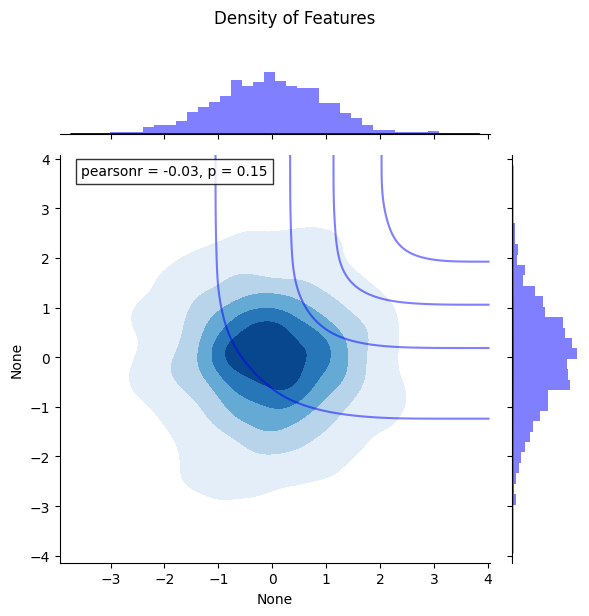

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Example data - replace with your actual data
data = np.random.normal(0, 1, (1000, 2))  # Example data with two features

# Clear previous figure
plt.clf()

# Create jointplot with KDE using a blue color scheme
g = sns.jointplot(x=data[:, 0], y=data[:, 1], kind='kde', 
                 cmap='Blues', shade=True, levels=6, 
                 color='blue', fill=True)

# Add cumulative contours (optional, to approximate CDF-like behavior)
g.plot_joint(sns.kdeplot, cumulative=True, levels=5, colors='blue', alpha=0.5,linewidths=0)

# Customize marginal plots (to match the example)
g.ax_marg_x.hist(data[:, 0], bins=30, color='blue', alpha=0.5)
g.ax_marg_y.hist(data[:, 1], bins=30, color='blue', alpha=0.5, orientation='horizontal')

# Add Pearson correlation (example values, replace with your data's correlation)
pearson_corr = np.corrcoef(data[:, 0], data[:, 1])[0, 1]
p_value = 0.15  # Replace with your actual p-value
g.ax_joint.text(0.05, 0.95, f'pearsonr = {pearson_corr:.2f}, p = {p_value:.2f}', 
                transform=g.ax_joint.transAxes, 
                bbox=dict(facecolor='white', alpha=0.8))

# Customize the plot
g.fig.suptitle('Density of Features', y=1.02)
g.fig.tight_layout()

# Save the figure

# Show the plot
plt.show()

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\seaborn\axisgrid.py:1832: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  func(x=self.x, y=self.y, **kwargs)
c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: The following kwargs were not used by contour: 'contour'
  cset = contour_func(


<Figure size 640x480 with 0 Axes>

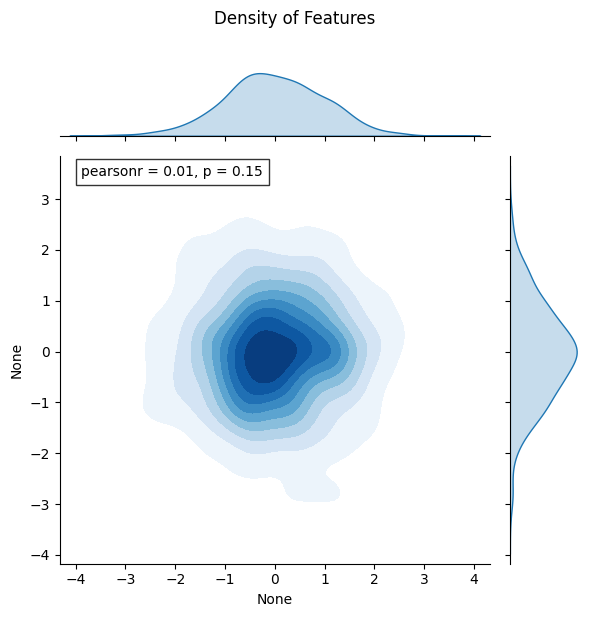

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Example data - replace with your actual data
data = np.random.normal(0, 1, (1000, 2))

# Clear previous figure
plt.clf()

# Create jointplot with KDE, removing contour lines
g = sns.jointplot(x=data[:, 0], y=data[:, 1], kind='kde', 
                 cmap='light:b', shade=True, fill=True, 
                 joint_kws={'contour': False})

# Add Pearson correlation (example values)
pearson_corr = np.corrcoef(data[:, 0], data[:, 1])[0, 1]
p_value = 0.15
g.ax_joint.text(0.05, 0.95, f'pearsonr = {pearson_corr:.2f}, p = {p_value:.2f}', 
                transform=g.ax_joint.transAxes, 
                bbox=dict(facecolor='white', alpha=0.8))

# Customize the plot
g.fig.suptitle('Density of Features', y=1.02)
g.fig.tight_layout()

# Save the figure
#g.savefig('graphs/density.svg')

# Show the plot
plt.show()

c:\Users\sachur\AppData\Local\anaconda3\envs\test1\Lib\site-packages\seaborn\distributions.py:1176: UserWarning: linewidths is ignored by contourf
  cset = contour_func(


FileNotFoundError: [Errno 2] No such file or directory: 'graphs/density.svg'

<Figure size 640x480 with 0 Axes>

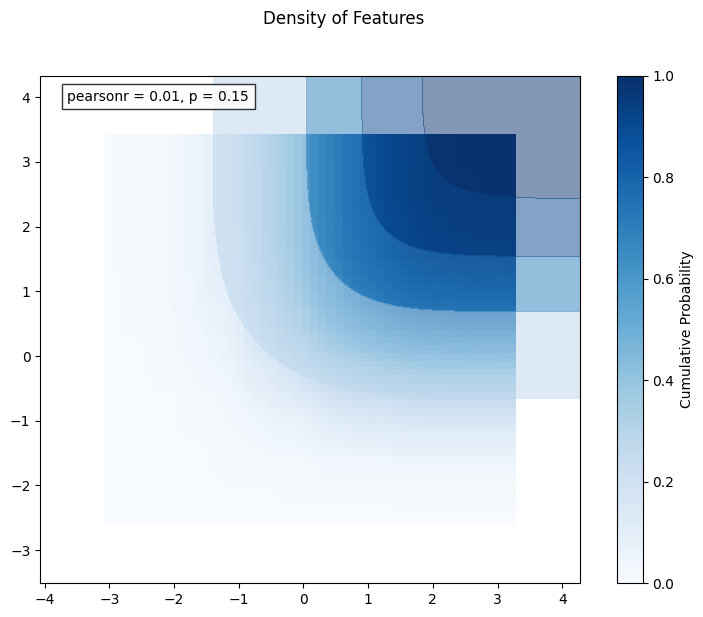

In [8]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Example data - replace with your actual data
data = np.random.normal(0, 1, (1000, 2))

# Clear previous figure
plt.clf()

# Calculate 2D histogram and CDF
H, xedges, yedges = np.histogram2d(data[:, 0], data[:, 1], bins=50)
Hcdf = np.cumsum(np.cumsum(H, axis=0), axis=1)
Hcdf = Hcdf / Hcdf.max()  # Normalize to [0,1]

# Create figure
plt.figure(figsize=(8, 6))
plt.imshow(Hcdf.T, origin='lower', cmap='Blues', 
          extent=[xedges[0], xedges[-1], yedges[0], yedges[-1]])

# Optionally add KDE contours (without lines if you prefer)
sns.kdeplot(x=data[:, 0], y=data[:, 1], cumulative=True, 
           levels=5, cmap='Blues', fill=True, alpha=0.5, 
           linewidths=0)  # Set linewidths=0 to remove contour lines

# Add Pearson correlation (example values)
pearson_corr = np.corrcoef(data[:, 0], data[:, 1])[0, 1]
p_value = 0.15
plt.text(0.05, 0.95, f'pearsonr = {pearson_corr:.2f}, p = {p_value:.2f}', 
         transform=plt.gca().transAxes, 
         bbox=dict(facecolor='white', alpha=0.8))

# Customize
plt.colorbar(label='Cumulative Probability')
plt.suptitle('Density of Features', y=1.02)
plt.tight_layout()

# Save
plt.savefig('graphs/density.svg')
plt.show()

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

# Read the CSV file
csv_path = r'S:/Sachuriga/nwb/test4neo/test/speed_analysis_results.csv'  # Adjust path if needed
df = pd.read_csv(csv_path, dtype={'H_counts_smoothed': float, 'speed_heatmap_smoothed': float})

# Define control and experimental animal IDs
# control_ids = ['65165', '65091', '63383', '66539', '65622']
# exp_ids = ['65588', '63385', '66538', '66537', '66922']


control_ids = [65165, 65091, 63383, 66539, 65622]
exp_ids = [65588,63385, 66538, 66537, 66922]

# Filter for 'A' sessions
df_a = df[df['session'] == 'A']

# Function to parse string array into numpy array
def parse_array(array_str):
    # Remove the surrounding quotes and split into rows
    array_str = array_str.strip('"')
    rows = array_str.split('\n')
    # Parse each row into numbers
    data = [list(map(float, row.split())) for row in rows if row.strip()]
    return np.array(data)

# Separate into control and experimental groups
control_df = df_a[df_a['animal_id'].isin(control_ids)]
exp_df = df_a[df_a['animal_id'].isin(exp_ids)]
exp_df


ValueError: could not convert string to float: '[[0.30591097 0.26541538 0.20700405 0.15712502 0.12860687 0.11909615\n  0.1209111  0.12930043 0.14292356 0.16009152 0.17703194 0.19017875\n  0.19951564 0.20916477 0.22438752 0.24711082 0.2732895  0.29497593\n  0.30671721 0.310172  ]\n [0.28266132 0.24692161 0.19527387 0.15123673 0.12656245 0.11940168\n  0.12274338 0.13188092 0.14520315 0.16123099 0.17721286 0.19078306\n  0.20217767 0.21428522 0.23033103 0.25081357 0.27188426 0.28731852\n  0.29381268 0.29442235]\n [0.24146368 0.2137647  0.17370716 0.13994171 0.122305   0.11963442\n  0.12596239 0.13668092 0.14979354 0.16419147 0.17873695 0.19288625\n  0.20718356 0.22267438 0.23982297 0.25745636 0.27225615 0.28030163\n  0.28084927 0.27836162]\n [0.19126973 0.17277507 0.14622439 0.12479642 0.1159281  0.11894617\n  0.12896404 0.14163207 0.154769   0.16778394 0.18114012 0.1959273\n  0.21283331 0.23126933 0.24964809 0.26593449 0.27758488 0.28234453\n  0.28078565 0.27750887]\n [0.14221555 0.13218295 0.11824498 0.1085597  0.10805974 0.11621359\n  0.12913804 0.14310892 0.15628199 0.16871781 0.1819432  0.19787661\n  0.21710298 0.23811153 0.25843714 0.27593145 0.288681   0.29515625\n  0.29589864 0.29439855]\n [0.10298387 0.09943308 0.09522671 0.09455677 0.1001203  0.11130922\n  0.12523174 0.13924175 0.15238556 0.16539193 0.18009386 0.19832068\n  0.22039703 0.24457421 0.26812729 0.28869052 0.30449209 0.31438776\n  0.31870922 0.31967797]\n [0.07829494 0.07882668 0.08073495 0.08553945 0.09427683 0.10626324\n  0.11958058 0.13284105 0.14615091 0.16074882 0.17823723 0.19985911\n  0.22569979 0.25408639 0.28187027 0.3057091  0.32346198 0.33471485\n  0.34048299 0.34259271]\n [0.06754212 0.07008797 0.07498126 0.08228834 0.09210077 0.10380377\n  0.1162956  0.12913894 0.14312492 0.15972057 0.18022277 0.20538663\n  0.23521111 0.26808369 0.30003851 0.3261714  0.3437415  0.35348355\n  0.35795996 0.35953157]\n [0.06585497 0.06910805 0.07498645 0.08295454 0.09280769 0.10423148\n  0.11674003 0.1302878  0.14567951 0.16424627 0.18713654 0.21500427\n  0.24793231 0.28429368 0.3193196  0.34677027 0.36347579 0.37124287\n  0.37404223 0.37481144]\n [0.06715688 0.07059238 0.07656139 0.08426554 0.09362217 0.10489325\n  0.11818937 0.13353265 0.15124003 0.17210665 0.19709152 0.22694744\n  0.2619187  0.30038591 0.33725676 0.36586083 0.38306    0.39118493\n  0.39453477 0.39578964]\n [0.06733393 0.07093572 0.07685703 0.08400239 0.09251877 0.10340304\n  0.11752266 0.13512711 0.15607757 0.18041473 0.20859165 0.24125807\n  0.2786824  0.31920042 0.35777932 0.38813275 0.40763125 0.41867565\n  0.42490124 0.42795842]\n [0.06589012 0.06974593 0.07577519 0.08252501 0.0902379  0.10050563\n  0.1150227  0.1346738  0.15937768 0.18863157 0.22218808 0.26023305\n  0.30267987 0.34741779 0.38921137 0.42223932 0.44464916 0.459041\n  0.46836588 0.47328449]\n [0.06572677 0.06963786 0.0756496  0.08215981 0.08938627 0.09917744\n  0.11384344 0.13504598 0.16319885 0.19774078 0.23801377 0.28373748\n  0.33417495 0.38620641 0.4337088  0.47083486 0.49647665 0.51381318\n  0.52562707 0.53199794]\n [0.07166512 0.0749137  0.07996713 0.0856054  0.09221356 0.10173454\n  0.1167144  0.1391351  0.16963299 0.20779431 0.25318774 0.30571961\n  0.36432535 0.42488604 0.4802505  0.52429076 0.55626312 0.57948919\n  0.59614907 0.60530882]\n [0.08850139 0.08983143 0.09197108 0.09482929 0.09955673 0.10843193\n  0.12390432 0.14734052 0.17856192 0.21693283 0.26282223 0.31738563\n  0.38026327 0.44733129 0.51142936 0.5666708  0.61201641 0.64915598\n  0.67754    0.69343879]\n [0.11851185 0.11630523 0.11287735 0.11012597 0.11076551 0.11783223\n  0.13341029 0.15726564 0.18723821 0.22189123 0.2627174  0.31302617\n  0.3742767  0.44369512 0.51564459 0.58541265 0.65107645 0.71063393\n  0.75824147 0.78523172]\n [0.15838188 0.15108816 0.13961616 0.12869943 0.1232341  0.12716118\n  0.14186055 0.16486877 0.19147267 0.21920119 0.2507906  0.29201511\n  0.34660805 0.41382812 0.49036536 0.57320201 0.65944337 0.74278854\n  0.81127116 0.85045966]\n [0.19860281 0.18543738 0.16482981 0.14487    0.13274973 0.13299224\n  0.1458904  0.16667896 0.18833018 0.20755677 0.228241   0.25826088\n  0.30327266 0.36428343 0.43995823 0.52874481 0.62721767 0.726098\n  0.80895252 0.85681606]\n [0.22862384 0.21021695 0.18164889 0.15411908 0.13665004 0.13384238\n  0.14476916 0.16283341 0.17944185 0.19086499 0.20179157 0.22143478\n  0.25662754 0.30940056 0.37951093 0.46625612 0.56621179 0.66908674\n  0.75664837 0.807713  ]\n [0.24350034 0.22200008 0.1888303  0.15708191 0.13675928 0.13231261\n  0.14198631 0.15819071 0.17160161 0.17832583 0.18342652 0.1966882\n  0.22543673 0.27210948 0.33685291 0.41928731 0.51617215 0.61727171\n  0.70418938 0.75521646]]'

'['